In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import flax
import jax 
import optax 
import tensorflow as tf
import tqdm 
import wandb

2024-04-12 14:44:40.698246: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 14:44:40.698267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 14:44:40.699123: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 14:44:41.294787: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from octo.data.dataset import make_single_dataset
from octo.data.utils.data_utils import NormalizationType
from octo.model.components.action_heads import L1ActionHead
from octo.model.components.tokenizers import LowdimObsTokenizer
from octo.model.octo_model import OctoModel
from octo.utils.jax_utils import initialize_compilation_cache
from octo.utils.spec import ModuleSpec 
from octo.utils.train_utils import (
    freeze_weights, 
    merge_params, 
    process_text, 
    TrainState, 
)

/home/nick/anaconda3/envs/octo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
initialize_compilation_cache() 
# Prevent tensorflow from using GPU memory since it's only used for data loading 
tf.config.set_visible_devices([], "GPU")

Initialized persistent compilation cache at /home/nick/.jax_compilation_cache


In [5]:
# Load pre-trained model 
pretrained_model = OctoModel.load_pretrained('hf://rail-berkeley/octo-small')
text_processor = pretrained_model.text_processor

Fetching 8 files: 100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 100162.48it/s]


In [6]:
# Make finetuning dataset
import matplotlib.pyplot as plt 
import pickle 
import numpy as np 

with open('../../octo_objects/recording2024_03_22-02_52_21_AM.pkl', 'rb') as f: 
    dataset = pickle.load(f) 

In [7]:
print(dataset['observation']['image_primary'].shape)

(297, 480, 640, 3)


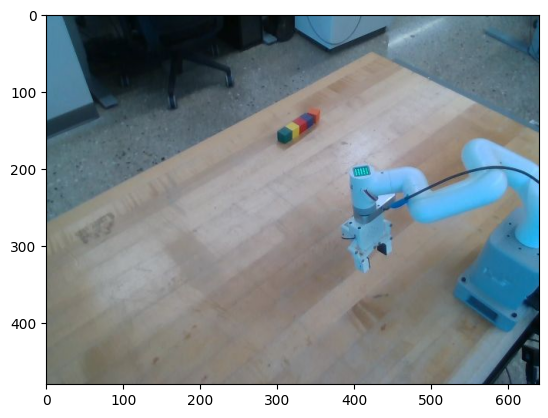

In [8]:
plt.figure() 
plt.imshow(dataset['observation']['image_primary'][0])
plt.show()

In [9]:
# Show all dataset keys 
def decompose_dict(data, parent_key=None):
    if isinstance(data, dict):
        for key, value in data.items():
            full_key = f"{parent_key}.{key}" if parent_key else key
            decompose_dict(value, full_key)
    elif isinstance(data, (list, tuple)):
        print(f"Key '{parent_key}': {type(data).__name__} of length {len(data)}")
    elif isinstance(data, np.ndarray):
        print(f"Key '{parent_key}': NumPy array of shape {data.shape}")
    else:
        print(f"Key '{parent_key}': {type(data).__name__}")

decompose_dict(dataset)

Key 'observation.image_primary': NumPy array of shape (297, 480, 640, 3)
Key 'observation.image_wrist': NumPy array of shape (297, 480, 640, 3)
Key 'observation.proprio': NumPy array of shape (297, 6)
Key 'observation.timestep': NumPy array of shape (297,)
Key 'task.image_primary': NumPy array of shape (297, 480, 640, 3)
Key 'task.image_wrist': NumPy array of shape (297, 480, 640, 3)
Key 'action': NumPy array of shape (297, 6)


In [10]:
# Then we can batch the data as well 

def batch_data(data_dict, batch_size, sequence_length):
    # Helper function to recursively batch data
    def batch_recursive(data, batch_indices):
        if isinstance(data, dict):
            return {key: batch_recursive(value, batch_indices) for key, value in data.items()}
        elif isinstance(data, np.ndarray):
            # Apply first level of batch index slicing (grouping into sequences)
            return data[batch_indices].reshape(-1, sequence_length, *data.shape[1:])
        else:
            raise TypeError(f"Unsupported data type {type(data)} encountered.")

    # Check all entries for numpy arrays
    def verify_data_structure(data):
        if isinstance(data, dict):
            for value in data.values():
                verify_data_structure(value)
        elif not isinstance(data, np.ndarray):
            raise ValueError("All leaf values in the data dictionary must be NumPy arrays.")

    verify_data_structure(data_dict)
    
    # Find the total number of samples available
    def find_num_samples(data):
        if isinstance(data, dict):
            return find_num_samples(next(iter(data.values())))
        elif isinstance(data, np.ndarray):
            return data.shape[0]

    num_samples = find_num_samples(data_dict)
    total_sequences = num_samples // sequence_length
    
    # Generate shuffled indices for full sequences
    sequence_indices = np.random.permutation(total_sequences) * sequence_length
    expanded_indices = np.array([np.arange(i, i + sequence_length) for i in sequence_indices]).flatten()

    # Calculate the number of batches
    num_batches = np.ceil(total_sequences / batch_size).astype(int)
    
    # Prepare batches
    batches = []
    for i in range(num_batches):
        batch_start = i * batch_size * sequence_length
        batch_end = min(batch_start + (batch_size * sequence_length), num_samples)
        batch_indices = expanded_indices[batch_start:batch_end]
        
        # Create a batch dictionary for the current batch
        batch = batch_recursive(data_dict, batch_indices)
        batch["observation"]["pad_mask"] = np.array([[True]])
        batches.append(batch)
        
    return batches

batches = batch_data(dataset, batch_size=1, sequence_length=1)
decompose_dict(batches[0])

Key 'observation.image_primary': NumPy array of shape (1, 1, 480, 640, 3)
Key 'observation.image_wrist': NumPy array of shape (1, 1, 480, 640, 3)
Key 'observation.proprio': NumPy array of shape (1, 1, 6)
Key 'observation.timestep': NumPy array of shape (1, 1)
Key 'observation.pad_mask': NumPy array of shape (1, 1)
Key 'task.image_primary': NumPy array of shape (1, 1, 480, 640, 3)
Key 'task.image_wrist': NumPy array of shape (1, 1, 480, 640, 3)
Key 'action': NumPy array of shape (1, 1, 6)


In [11]:
# Also generate dataset statistics 
dataset_statistics = {
    "action": {
        "mean" : np.mean(dataset["action"], axis=0).tolist(), 
        "std": np.std(dataset["action"], axis=0).tolist(), 
        "max": np.max(dataset["action"], axis=0).tolist(), 
        "min": np.min(dataset["action"], axis=0).tolist(), 
    }, 
    "proprio" : {
        "mean": np.mean(dataset["observation"]["proprio"], axis=0).tolist(), 
        "std": np.std(dataset["observation"]["proprio"], axis=0).tolist(), 
        "max": np.max(dataset["observation"]["proprio"], axis=0).tolist(), 
        "min": np.min(dataset["observation"]["proprio"], axis=0).tolist(),
    }, 
    "num_transitions": 297, 
    "num_trajectories": 1
}

In [12]:
# Then we need to modify the model config to match the shape of inputs/outputs we have 
config = pretrained_model.config

In [13]:
config["model"]

{'observation_tokenizers': {'primary': {'module': 'octo.model.components.tokenizers',
   'name': 'ImageTokenizer',
   'args': [],
   'kwargs': {'obs_stack_keys': ['image_primary'],
    'task_stack_keys': ['image_primary'],
    'encoder': {'module': 'octo.model.components.vit_encoders',
     'name': 'SmallStem16',
     'args': [],
     'kwargs': {}}}},
  'wrist': {'module': 'octo.model.components.tokenizers',
   'name': 'ImageTokenizer',
   'args': [],
   'kwargs': {'obs_stack_keys': ['image_wrist'],
    'task_stack_keys': ['image_wrist'],
    'encoder': {'module': 'octo.model.components.vit_encoders',
     'name': 'SmallStem16',
     'args': [],
     'kwargs': {}}}}},
 'task_tokenizers': {'language': {'module': 'octo.model.components.tokenizers',
   'name': 'LanguageTokenizer',
   'args': [],
   'kwargs': {'encoder': 't5-base', 'finetune_encoder': False}}},
 'heads': {'action': {'module': 'octo.model.components.action_heads',
   'name': 'DiffusionActionHead',
   'args': [],
   'kwargs'

## Changing model config
We need to add proprio joint input, alongside needing to change the action dimension to 6 to match our robot

In [14]:
config["model"]["observation_tokenizers"]["proprio"] = ModuleSpec.create(
    LowdimObsTokenizer, 
    n_bins = 256, 
    bin_type = "normal", 
    low = -2.0, 
    high = 2.0, 
    obs_keys = ["proprio"]
)

In [15]:
# Override the action head to meet the dimension requirement 
config["model"]["heads"]["action"] = ModuleSpec.create(
    L1ActionHead, 
    pred_horizon=1, 
    action_dim=6, 
    readout_key="readout_action", 
)

In [16]:
# Initialize weights for modified Octo model, then merge in all applicable pre-trained weights 
# new position encodings for proprio inputs & weights for new action head will remain "from scratch" 
model = OctoModel.from_config(
    config, 
    example_batch=batches[0], 
    text_processor=text_processor, 
    verbose=True, 
    dataset_statistics=dataset_statistics,
)

TypeError: Cannot concatenate arrays with different numbers of dimensions: got (1, 1, 480, 640, 3), (1, 1, 1, 480, 640, 3).